# Universidad Autonoma de Aguascalientes
## Centro de Ciencias Basicas
## Ing. En Computacion Inteligente
## Septimo Semestre / Metaherisitcas II
### Prof. Francisco Javier Luna Rosas

### Equipo:
|Nombre|ID|
| ---- | --- |
|César Eduardo Elias del Hoyo |262045|
|José Luis Sandoval Pérez |261731|
|Diego Emanuel Saucedo Ortega |261230|
|Carlos Daniel Torres Macías |244543|

## Examen I: Uso de PSO para asignacion de procesamiento de resenas de cine en paralelo
El objetivo del siguiente documento es desarrollar la asignacion por medio del algoritmo metaheuristico de PSO para el procesamiento de una gran cantidad de resenas de cine, las cuales en caso de ser procesadas de forma secuencial podrian demorar mas, se propone un procesamiento en paralelo que ayude a completar la tarea en menor tiempo.

### Importar librerias

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [75]:
# Inicializar parámetros
num_particles = 30
num_dimensions = 1  # Cambiado a 1 dimensión
max_iterations = 100
w = 0.5  # Inercia
c1 = 1.5  # Coeficiente cognitivo
c2 = 1.5  # Coeficiente social

NUM_PROCESADORES = 8

### Funcion objetivo

In [76]:
def porcentaje_balanceados(particula):
    promedio_procesadores = np.mean(particula)
    th_H = 1.2 * promedio_procesadores
    th_L = 0.8 * promedio_procesadores
    
    balanceado = 0
    for x in particula:
        if x>th_H and x<th_L:
            balanceado += 1
    return balanceado/NUM_PROCESADORES

def objective_function(particula):
    # tomamos el maximo de toda la particula
    maxspan = max(particula)
    # calculamos el promedio de uso de procesadores
    promedio_uso = np.mean(particula/maxspan)
    # determinamos el limite de sobrecarga de procesador
    porcentaje_carga = porcentaje_balanceados(particula)
    
    return (1/maxspan) + promedio_uso + porcentaje_carga   

### Generar particulas

In [77]:
def generar_particulas(num_particulas,num_resenas):
    particulas = []

    for i in range(num_particles):
        resenas_restantes = num_resenas
        
        # Generar n-1 números aleatorios entre 0 y m
        arreglo = np.random.randint(0, num_resenas, NUM_PROCESADORES-1)
        # Calcular el último número para que la suma sea m
        ultimo_numero = num_resenas - np.sum(arreglo)
        # Añadir el último número al arreglo
        arreglo = np.append(arreglo, ultimo_numero)
        # Si el último número es negativo, ajustar el arreglo
        while ultimo_numero < 0:
            arreglo = np.random.randint(0, num_resenas, NUM_PROCESADORES-1)
            ultimo_numero = num_resenas - np.sum(arreglo)
            arreglo = np.append(arreglo, ultimo_numero)
        
        particulas.append(arreglo)
    
    return particulas
            

### Implementacion PSO

In [78]:
def ejecutar_PSO(num_resenas):

    # Inicializar partículas
    particles = generar_particulas(num_particles,num_resenas)

    velocities = np.random.randint(-5, 5, [num_particles,NUM_PROCESADORES])  # Velocidades aleatorias entre -5 y 5 
    personal_best_positions = particles.copy()
    personal_best_scores = np.apply_along_axis(objective_function, 1, particles)
    global_best_position = personal_best_positions[np.argmax(personal_best_scores)]

    # PSO loop
    for iteration in range(max_iterations):
        for i in range(num_particles):
            # Actualizar velocidad
            r1, r2 = np.random.rand(2)
            # actualizamos cada conjunto de velocidades
            for index in range(NUM_PROCESADORES):
                velocities[i][index] = (w * velocities[i][index] +
                                 c1 * r1 * (personal_best_positions[i][index] - particles[i][index]) +
                                 c2 * r2 * (global_best_position[index] - particles[i][index])).astype(int)

                # Actualizar posición
                particles[i][index] += velocities[i][index]

            # ajustar el que sea el total de resenas
            resto_resenas_particula = num_resenas - np.sum(particles[i])

            if resto_resenas_particula > 0:
                indice_max = np.argmax(particles[i])
                particles[i][indice_max] += resto_resenas_particula
            elif resto_resenas_particula < 0:
                indice_min = np.argmin(particles[i])
                particles[i][indice_min] += resto_resenas_particula

            # Evaluar nueva posición
            score = objective_function(particles[i])

            # Actualizar mejor posición personal
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = particles[i]

        # Actualizar mejor posición global
        global_best_position = personal_best_positions[np.argmax(personal_best_scores)]

        # Imprimir progreso
        # print(f"Iteración {iteration+1}/{max_iterations}, Mejor puntuación global: {min(personal_best_scores)}")

    print("Mejor posición encontrada:", global_best_position)
    print("Fitness:",objective_function(global_best_position))
    print("Tiempo total:",np.max(global_best_position))
    
    return global_best_position

## Resultados de optimizacion en paralelo

Se aplica PSO a diferentes numeros de resenas a procesar en 8 procesadores

In [79]:
NUM_RESENAS = [10000,20000,30000,50000,100000]
# almacenamos los tiempos totales de cada prueba
tiempo_total_paralelo = []

for resenas in NUM_RESENAS:
    print("Para",resenas,"resenas:")
    gb_position = ejecutar_PSO(resenas)
    tiempo_total_paralelo.append(np.max(gb_position))
    print("")

Para 10000 resenas:
Mejor posición encontrada: [1779 1604  234 1063 2086  849 1144 1241]
Fitness: 0.599712368168744
Tiempo total: 2086

Para 20000 resenas:
Mejor posición encontrada: [3012 3899 2272 2476  926 2052 1416 3947]
Fitness: 0.6336458069419814
Tiempo total: 3947

Para 30000 resenas:
Mejor posición encontrada: [1631 5319 5079 4115 2146 6492 2262 2956]
Fitness: 0.5777880468268638
Tiempo total: 6492

Para 50000 resenas:
Mejor posición encontrada: [ 2325  9212 10804  8761  3320 11346  2175  2057]
Fitness: 0.5509430636347612
Tiempo total: 11346

Para 100000 resenas:
Mejor posición encontrada: [21703  6697  3700 17829 18124  1101 17239 13607]
Fitness: 0.5760033175137079
Tiempo total: 21703



### Comparacion con procesamiento en serie

In [80]:
resultados = {"Num.Resenas":NUM_RESENAS,"P.Serie":NUM_RESENAS,"P.Paralelo":tiempo_total_paralelo}

df_res = pd.DataFrame(resultados)
df_res

,Num.Resenas,P.Serie,P.Paralelo
0,10000,10000,2086
1,20000,20000,3947
2,30000,30000,6492
3,50000,50000,11346
4,100000,100000,21703


## Grafico comparativo

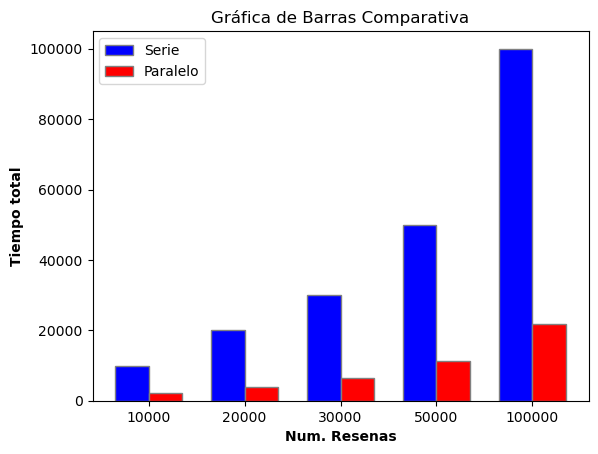

In [81]:
# Crear la gráfica de barras
bar_width = 0.35
r1 = range(len(df_res['P.Serie']))
r2 = [x + bar_width for x in r1]

plt.bar(r1, df_res['P.Serie'], color='b', width=bar_width, edgecolor='grey', label='Serie')
plt.bar(r2, df_res['P.Paralelo'], color='r', width=bar_width, edgecolor='grey', label='Paralelo')

# Añadir etiquetas y título
plt.xlabel('Num. Resenas', fontweight='bold')
plt.ylabel('Tiempo total', fontweight='bold')
plt.title('Gráfica de Barras Comparativa')
plt.xticks([r + bar_width/2 for r in range(len(df_res['P.Serie']))], df_res['Num.Resenas'])

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

### Conclusion
Mediante la implementacion del PSO en la asignacion de procesamiento en paralelo, se pueden atacar varios de los problemas que pueden surgir al buscar la optimizacion como las sobrecargas, la reparticion equitativa y evidentemente, el tiempo de procesamiento requerido.
Si bien la idea de utilizar el PSO es sencilla, se requiere poder entender la abstraccion de las particulas para lograr el desarrollo deseado y por ende, la mejor respuesta posible.